<a href="https://colab.research.google.com/github/SZ330/EE344-Stock-Market-Predictor/blob/main/SPY_Predictors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SPY Predictors for 1995 - 2025
This notebook builds and evaluates a machine learning model to predict whether the SPY ETF will go up or down the next trading day based on historical market data. It begins by loading a feature-engineered dataset spanning 1995–2025, removes neutral (no-change) days, and selects a set of technical and calendar-based predictors such as lagged returns, rolling volatility, moving-average ratios, momentum, and volume features. The data is split chronologically into a training period (1995-2010) and a testing period (2010-2025) to preserve the time-series structure and prevent leakage. Three classification models: Logistic Regression, Linear SVM, and Random Forest, are trained (with appropriate scaling for linear models) and evaluated using accuracy, precision, recall, and F1-score. The overall goal of the notebook is to compare these models and determine whether historical price and volume patterns contain predictive signal for next-day market direction, while assessing generalization performance on truly out-of-sample future data.

#### Step 1: Import libraries

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline # (May need it, not using it for now)

#### Step 2: Load data set and drop columns we don't need

In [16]:
# Read the file path
CSV_PATH = 'SPY_1995_2025_feature_expansion.csv'
df = pd.read_csv(CSV_PATH)

df = df[df['y_next_dir'] != 0].reset_index(drop=True)
df['y_next_dir'].value_counts()

# Drop the date column
df_new = df.drop(columns=['Open', 'High', 'Low', 'Close',
                          'dom', 'weekofyear', 'ret_1d_lag6', 'ret_1d_lag7',
                          'ret_1d_lag8', 'ret_1d_lag9', 'ret_1d_lag10',
                          'ma_close_5d', 'ma_close_10d', 'ma_close_20d',
                          'ma_close_50d', 'close_minus_ma_5d', 'close_minus_ma_10d',
                          'close_minus_ma_20d', 'close_minus_ma_50d', 'vol_z_5d',
                          'vol_z_20d'])

# Print statements for sanity check
print(df_new.head())
print(df_new.tail())
print(df_new.shape)

         Date  Volume  dow  month    ret_1d  ret_1d_lag1  ret_1d_lag2  \
0  1995-03-14  223300    1      3  0.007302    -0.000951     0.014805   
1  1995-03-15  278500    2      3 -0.001891     0.007302    -0.000951   
2  1995-03-16   20400    3      3  0.005999    -0.001891     0.007302   
3  1995-03-20   91700    0      3  0.000000    -0.004394     0.005999   
4  1995-03-21  104400    1      3 -0.002522     0.000000    -0.004394   

   ret_1d_lag3  ret_1d_lag4  ret_1d_lag5  ...  close_over_ma_10d  \
0    -0.000322     0.002581    -0.007682  ...           1.014548   
1     0.014805    -0.000322     0.002581  ...           1.011014   
2    -0.000951     0.014805    -0.000322  ...           1.014973   
3    -0.001891     0.007302    -0.000951  ...           1.007368   
4     0.005999    -0.001891     0.007302  ...           1.002789   

   close_over_ma_20d  close_over_ma_50d    mom_5d   mom_10d   mom_20d  \
0           1.016319           1.039040  0.023548  0.011476  0.024871   
1     

#### Step 3: Split the data into 15 year of train and 15 years of test

In [18]:
# Explicitly mention features and target
FEATURE_COLS = ['Volume','dow','month','ret_1d','ret_1d_lag1',
                 'ret_1d_lag2','ret_1d_lag3','ret_1d_lag4','ret_1d_lag5',
                 'ret_vol_5d','ret_vol_10d','ret_vol_20d','close_over_ma_5d',
                 'close_over_ma_10d','close_over_ma_20d','close_over_ma_50d',
                 'mom_5d','mom_10d','mom_20d','vol_chg_1d','vol_mean_5d',
                 'vol_mean_20d']
TARGET_COL = "y_next_dir"

X = df_new[FEATURE_COLS]
y = df_new[TARGET_COL]

# Split train and test data down the middle (2010)
split_date = "2010-01-04"
train_df = df_new[df_new["Date"] < split_date]
test_df  = df_new[df_new["Date"] >= split_date]

# Sanity check
print("TRAIN RANGE:")
print(train_df["Date"].min(), "to", train_df["Date"].max())

print("\nTEST RANGE:")
print(test_df["Date"].min(), "to", test_df["Date"].max())

TRAIN RANGE:
1995-03-14 to 2009-12-31

TEST RANGE:
2010-01-04 to 2025-12-29


#### Step 4: Separate train and test data

In [19]:
# Separate train and test data
X_train = train_df[FEATURE_COLS]
y_train = train_df[TARGET_COL]

X_test  = test_df[FEATURE_COLS]
y_test  = test_df[TARGET_COL]

# Sanity check
print(X_train.shape, X_test.shape)
print(y_train.value_counts())
print(y_test.value_counts())

(3704, 22) (4010, 22)
y_next_dir
 1.0    1963
-1.0    1741
Name: count, dtype: int64
y_next_dir
 1.0    2212
-1.0    1798
Name: count, dtype: int64


Notes for Dinuka
1. Do the extra features look good?

2. Ask about dropped features (should we drop 'Date' even though it is time-series)

3. 2000 (Dot Com bubble), 2001 (9/11), 2008 (Housing crisis)

#### Step 5: Define metrics (Accuracy, Precision, Recall, and F-1 score)

In [6]:
RANDOM_STATE = 42
def metrics(y_true, y_pred):
    """Return (accuracy, precision, recall, f1)."""
    acc = accuracy_score(y_true, y_pred)

    # Use 'binary' for binary classification, otherwise fallback to macro.
    avg = "binary" if len(np.unique(y_true)) == 2 else "macro"

    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average=avg, zero_division=0
    )
    return acc, prec, rec, f1

#### Step 6: Define the models we will use

In [12]:
models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(solver="saga", max_iter=5000, n_jobs=-1, random_state=42))
    ]),
    "SVM (LinearSVC)": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LinearSVC(random_state=42, max_iter=20000))
    ]),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
}

models

{'Logistic Regression': Pipeline(steps=[('scaler', StandardScaler()),
                 ('model',
                  LogisticRegression(max_iter=5000, n_jobs=-1, random_state=42,
                                     solver='saga'))]),
 'SVM (LinearSVC)': Pipeline(steps=[('scaler', StandardScaler()),
                 ('model', LinearSVC(max_iter=20000, random_state=42))]),
 'Random Forest': RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)}

#### Step 7: Training model, predicting, and printing metrics

In [25]:
results = []

for name, clf in models.items():
    clf.fit(X_train, y_train)

    yhat_tr = clf.predict(X_train)
    yhat_te = clf.predict(X_test)

    tr_acc, tr_prec, tr_rec, tr_f1 = metrics(y_train, yhat_tr)
    te_acc, te_prec, te_rec, te_f1 = metrics(y_test, yhat_te)

    results.append([
        name,
        tr_acc, tr_prec, tr_rec, tr_f1,
        te_acc, te_prec, te_rec, te_f1
    ])

cols = [
    "Model",
    "Train Acc", "Train Prec", "Train Rec", "Train F1",
    "Test Acc", "Test Prec", "Test Rec", "Test F1",
]

out = pd.DataFrame(results, columns=cols).sort_values("Test F1", ascending=False).reset_index(drop=True)

pd.set_option("display.max_colwidth", 80)
print("\n=== Results (sorted by Test F1) ===")
print(out.to_string(index=False, formatters={
    "Train Acc": "{:.4f}".format,
    "Train Prec": "{:.4f}".format,
    "Train Rec": "{:.4f}".format,
    "Train F1": "{:.4f}".format,
    "Test Acc": "{:.4f}".format,
    "Test Prec": "{:.4f}".format,
    "Test Rec": "{:.4f}".format,
    "Test F1": "{:.4f}".format,
}))


=== Results (sorted by Test F1) ===
              Model Train Acc Train Prec Train Rec Train F1 Test Acc Test Prec Test Rec Test F1
    SVM (LinearSVC)    0.5400     0.5424    0.8431   0.6602   0.5471    0.5549   0.9051  0.6880
Logistic Regression    0.5373     0.5409    0.8395   0.6579   0.5456    0.5539   0.9055  0.6874
      Random Forest    1.0000     1.0000    1.0000   1.0000   0.5262    0.5546   0.7161  0.6251


#### Step 8: Confusion matrices

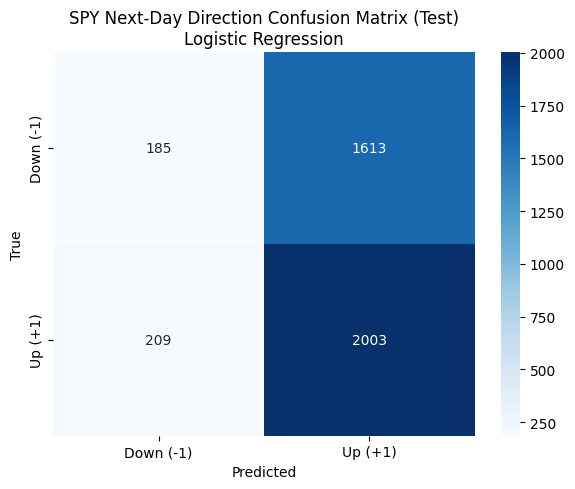


Logistic Regression Confusion Matrix:
 [[ 185 1613]
 [ 209 2003]]


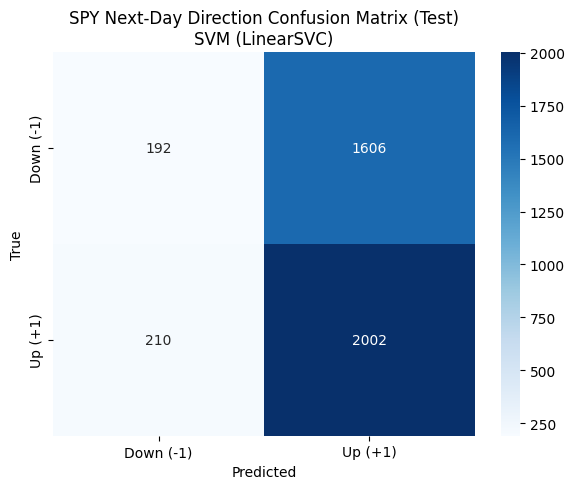


SVM (LinearSVC) Confusion Matrix:
 [[ 192 1606]
 [ 210 2002]]


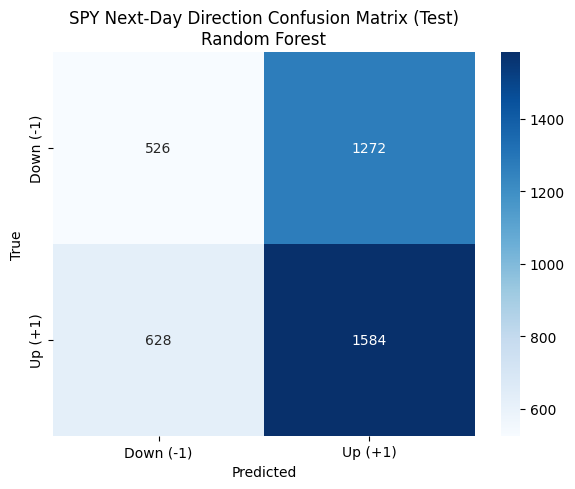


Random Forest Confusion Matrix:
 [[ 526 1272]
 [ 628 1584]]


In [28]:
labels = [-1, 1]

for name, clf in models.items():
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=labels)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm,
                annot=True,
                fmt="d",
                cmap="Blues",
                xticklabels=["Down (-1)", "Up (+1)"],
                yticklabels=["Down (-1)", "Up (+1)"])

    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"SPY Next-Day Direction Confusion Matrix (Test)\n{name}")
    plt.tight_layout()
    plt.show()

    print(f"\n{name} Confusion Matrix:\n", cm)

#### Step 9: Print actual vs predicted result for sanity check

In [30]:
for name, clf in models.items():
    print("\n" + "="*60)
    print(f"{name} — TEST Comparison")

    y_pred_test = clf.predict(X_test)

    comparison = pd.DataFrame({
        "Date": test_df["Date"].values,
        "True": y_test.values,
        "Predicted": y_pred_test
    })

    print(comparison.head(15))


Logistic Regression — TEST Comparison
          Date  True  Predicted
0   2010-01-04   1.0       -1.0
1   2010-01-05   1.0       -1.0
2   2010-01-06   1.0        1.0
3   2010-01-07   1.0        1.0
4   2010-01-08   1.0        1.0
5   2010-01-11  -1.0        1.0
6   2010-01-12   1.0        1.0
7   2010-01-13   1.0        1.0
8   2010-01-14  -1.0        1.0
9   2010-01-15   1.0        1.0
10  2010-01-19  -1.0        1.0
11  2010-01-20  -1.0        1.0
12  2010-01-21  -1.0        1.0
13  2010-01-22   1.0        1.0
14  2010-01-25  -1.0        1.0

SVM (LinearSVC) — TEST Comparison
          Date  True  Predicted
0   2010-01-04   1.0       -1.0
1   2010-01-05   1.0       -1.0
2   2010-01-06   1.0        1.0
3   2010-01-07   1.0        1.0
4   2010-01-08   1.0        1.0
5   2010-01-11  -1.0        1.0
6   2010-01-12   1.0        1.0
7   2010-01-13   1.0        1.0
8   2010-01-14  -1.0        1.0
9   2010-01-15   1.0        1.0
10  2010-01-19  -1.0        1.0
11  2010-01-20  -1.0        1.

# Results